# Figure 10: Confusion Matrices Comparison

This notebook generates confusion matrices comparing UMAP-based simulation origin probabilities (SOPs) with autoencoder predictions for galaxy simulation classification.

**Two figures are generated:**
1. **Unweighted Confusion Matrices:** Side-by-side comparison
2. **Weighted Confusion Matrices:** Side-by-side comparison

**Each figure shows:**
- **Left panel:** UMAP-based SOPs confusion matrix
- **Right panel:** Autoencoder confusion matrix

Matrices are normalized by true labels to show recall (true positive rate) for each simulation.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib.colors import Normalize
import sys
import pickle
import cmasher as cmr
from sklearn.metrics import confusion_matrix, accuracy_score

from scipy.interpolate import RegularGridInterpolator

# Add src to path
sys.path.append('../src')

from utils.analysis import (sim_name, colors, times, boxing, 
                           P_x_s, P_s_x)
from utils.data_processing import load_autoencoder_data
from utils.plotting import plot_cm

# LaTeX font setup
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

%matplotlib inline

## Load Data

In [8]:
# Load processed simulation data
with open('../data/sim_data_processed.pkl', 'rb') as f:
    sim_data = pickle.load(f)

# Load UMAP embeddings
combined_labels = np.load('../data/combined_labels.npy')
embedding = np.load('../data/umap_embedding.npy')
combined_sfh = np.load('../data/combined_sfh.npy')

# Reconstruct UMAP embeddings by simulation
for i, sim in enumerate(sim_name):
    if sim_data[sim] is not None:
        sim_mask = combined_labels == i
        sim_data[sim]['umap'] = embedding[sim_mask]

print("Loaded UMAP data by simulation:")
for sim in sim_name:
    if sim_data[sim] is not None:
        print(f"{sim:>15s}: {sim_data[sim]['umap'].shape[0]:>8,d} galaxies")

Loaded UMAP data by simulation:
          EAGLE:    7,445 galaxies
      Illustris:   19,354 galaxies
   IllustrisTNG:   12,220 galaxies
         Mufasa:    1,900 galaxies
          Simba:    1,982 galaxies
         SC-SAM:   12,821 galaxies
UniverseMachine:    7,361 galaxies


In [9]:
# Load autoencoder predictions
ae_data = load_autoencoder_data(sim_data)

print("Loaded autoencoder data:")

Loaded predictions_sfh.npy: shape (63083, 139)
Loaded predictions_sfh_w.npy: shape (63083, 139)
Loaded predictions_sfr.npy: shape (63083, 2)
Loaded predictions_sfr_w.npy: shape (63083, 2)
Loaded predictions_sim.npy: shape (63083, 7)
Loaded predictions_sim_w.npy: shape (63083, 7)
Reordering predictions from sim_name_z to sim_name order...
Reordered predictions_sfh: shape (63083, 139)
Reordered predictions_sfh_w: shape (63083, 139)
Reordered predictions_sfr: shape (63083, 2)
Reordered predictions_sfr_w: shape (63083, 2)
Reordered predictions_sim: shape (63083, 7), columns reordered to sim_name
Reordered predictions_sim_w: shape (63083, 7), columns reordered to sim_name
Split EAGLE: 7445 galaxies
Split Illustris: 19354 galaxies
Split IllustrisTNG: 12220 galaxies
Split Mufasa: 1900 galaxies
Split Simba: 1982 galaxies
Split SC-SAM: 12821 galaxies
Split UniverseMachine: 7361 galaxies
Loaded autoencoder data:


In [10]:
# Create battleship grid structure (needed for SOP calculation)
result = np.column_stack((embedding, combined_labels))
umaps = boxing(result[:,0], result[:,1], result)

print("Created battleship grid structure for SOP calculations")

Created battleship grid structure for SOP calculations


## Calculate UMAP-based Predictions

In [11]:
# Create high-resolution grid for SOP calculation
xx, yy = np.mgrid[0:10:100j, 0:10:100j]
pos = np.vstack([xx.ravel(), yy.ravel()])

In [12]:
print("Calculating UMAP-based simulation origin probabilities for Method 1 (Galaxy count weighting)...")

# Method 1: Galaxy count weighted approach (bias=True, normint=False)
p_s_x = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
              normint=False, bias=True, mask=False)

for sim in sim_name:
    if sim_data[sim] is not None:
        max_prob = np.nanmax(p_s_x[sim])
        print(f"{sim:>15s}: Max probability = {max_prob:.4f}")

# Create 2D interpolators for p_s_x over the grid for each simulation
p_s_x_interp = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        # Reshape p_s_x[sim] to 2D grid (100x100)
        p_grid = p_s_x[sim].reshape(100, 100)
        # Create interpolator
        p_s_x_interp[sim] = RegularGridInterpolator((xx[:, 0], yy[0, :]), p_grid, 
                                                   bounds_error=False, fill_value=np.nan)
        
# Evaluate over individual galaxy positions
p_s_x_eval = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        p_s_x_eval[sim] = p_s_x_interp[sim](embedding)

# Normalize over each galaxy across simulations
for i in range(len(embedding)):
    total = sum(p_s_x_eval[sim][i] for sim in sim_name if sim_data[sim] is not None)
    if total > 0:
        for sim in sim_name:
            if sim_data[sim] is not None:
                p_s_x_eval[sim][i] /= total

# Get predicted simulation (highest probability)
predicted_sim = [np.argmax([p_s_x_eval[sim][i] for sim in sim_name]) for i in range(len(embedding))]

# Calculate probability of correct class
correct_class_prob = [p_s_x_eval[sim][i] for i, sim in enumerate(sim_name[combined_labels])]

# Calculate accuracy (correct prediction)
accuracy = (predicted_sim == combined_labels.astype(int)).astype(float)

print(f"\nCalculated probabilities and accuracy for {len(embedding):,} galaxies.")
print(f"Overall accuracy (Method 1): {np.mean(accuracy)*100:.2f}%")

Calculating UMAP-based simulation origin probabilities for Method 1 (Galaxy count weighting)...


c:\Users\joshs\Dropbox\GitHub\savelli-kustec-gal-sfh\notebooks\../src\utils\analysis.py:312: RuntimeWarning: invalid value encountered in subtract
  log_p_s_x_sim = log_p_x_s[sim] + log_p_s[sim] - log_p_x


          EAGLE: Max probability = 0.3880
      Illustris: Max probability = 0.8358
   IllustrisTNG: Max probability = 0.5500
         Mufasa: Max probability = 0.3840
          Simba: Max probability = 0.4560
         SC-SAM: Max probability = 0.9566
UniverseMachine: Max probability = 0.7109

Calculated probabilities and accuracy for 63,083 galaxies.
Overall accuracy (Method 1): 49.36%


In [13]:
print("Calculating UMAP-based simulation origin probabilities for Method 2 (equally weighted)...")

# Method 2: Equal weighting approach (bias=False, normint=False)
p_s_x2 = P_s_x(x=pos, sim_name=sim_name, sim_data=sim_data, umaps=umaps, 
               normint=False, bias=False, mask=False)

for sim in sim_name:
    if sim_data[sim] is not None:
        max_prob = np.nanmax(p_s_x2[sim])
        print(f"{sim:>15s}: Max probability = {max_prob:.4f}")

from scipy.interpolate import RegularGridInterpolator

# Create 2D interpolators for p_s_x over the grid for each simulation
p_s_x2_interp = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        # Reshape p_s_x[sim] to 2D grid (100x100)
        p_grid = p_s_x2[sim].reshape(100, 100)
        # Create interpolator
        p_s_x2_interp[sim] = RegularGridInterpolator((xx[:, 0], yy[0, :]), p_grid, 
                                                   bounds_error=False, fill_value=np.nan)
        
# Evaluate over individual galaxy positions
p_s_x2_eval = {}
for sim in sim_name:
    if sim_data[sim] is not None:
        p_s_x2_eval[sim] = p_s_x2_interp[sim](embedding)

# Normalize over each galaxy across simulations
for i in range(len(embedding)):
    total = sum(p_s_x2_eval[sim][i] for sim in sim_name if sim_data[sim] is not None)
    if total > 0:
        for sim in sim_name:
            if sim_data[sim] is not None:
                p_s_x2_eval[sim][i] /= total

# Get predicted simulation (highest probability)
predicted_sim2 = [np.argmax([p_s_x2_eval[sim][i] for sim in sim_name]) for i in range(len(embedding))]

# Calculate probability of correct class
correct_class_prob2 = [p_s_x2_eval[sim][i] for i, sim in enumerate(sim_name[combined_labels])]

# Calculate accuracy (correct prediction)
accuracy2 = (predicted_sim2 == combined_labels.astype(int)).astype(float)

print(f"\nCalculated probabilities and accuracy for {len(embedding):,} galaxies.")
print(f"Overall accuracy (Method 2): {np.mean(accuracy2)*100:.2f}%")

Calculating UMAP-based simulation origin probabilities for Method 2 (equally weighted)...
          EAGLE: Max probability = 0.4861
      Illustris: Max probability = 0.7024
   IllustrisTNG: Max probability = 0.4853
         Mufasa: Max probability = 0.6282
          Simba: Max probability = 0.6689
         SC-SAM: Max probability = 0.8865
UniverseMachine: Max probability = 0.4270

Calculated probabilities and accuracy for 63,083 galaxies.
Overall accuracy (Method 2): 44.99%


In [20]:
sop_w_pred = predicted_sim
sop_unw_pred = predicted_sim2

## Get Autoencoder Predictions

In [ ]:
# Get predicted simulations from autoencoder
ae_unw_pred = np.argmax(ae_data['predictions_sim'], axis=1)
ae_w_pred = np.argmax(ae_data['predictions_sim_w'], axis=1)

print(f"Autoencoder unweighted accuracy: {accuracy_score(combined_labels.astype(int), ae_unw_pred):.3f}")
print(f"Autoencoder weighted accuracy: {accuracy_score(combined_labels.astype(int), ae_w_pred):.3f}")

Autoencoder unweighted accuracy: 0.914
Autoencoder weighted accuracy: 0.913


## Calculate Confusion Matrices

In [21]:
# Calculate confusion matrices (normalized by true labels)
true_labels = combined_labels.astype(int)

# Unweighted confusion matrices
cm_sop_unw = confusion_matrix(true_labels, sop_unw_pred, labels=range(len(sim_name)), 
                             normalize='true')
cm_ae_unw = confusion_matrix(true_labels, ae_unw_pred, labels=range(len(sim_name)), 
                            normalize='true')

# Weighted confusion matrices
cm_sop_w = confusion_matrix(true_labels, sop_w_pred, labels=range(len(sim_name)), 
                           normalize='true')
cm_ae_w = confusion_matrix(true_labels, ae_w_pred, labels=range(len(sim_name)), 
                          normalize='true')

print("Confusion matrices calculated")
print(f"Matrix shape: {cm_sop_unw.shape}")

# Print diagonal accuracies (recall per simulation)
print("\nPer-simulation recall (unweighted):")
for i, sim in enumerate(sim_name):
    print(f"  {sim:>15s}: SOP {cm_sop_unw[i,i]:.3f}, AE {cm_ae_unw[i,i]:.3f}")

print("\nPer-simulation recall (weighted):")
for i, sim in enumerate(sim_name):
    print(f"  {sim:>15s}: SOP {cm_sop_w[i,i]:.3f}, AE {cm_ae_w[i,i]:.3f}")

Confusion matrices calculated
Matrix shape: (7, 7)

Per-simulation recall (unweighted):
            EAGLE: SOP 0.467, AE 0.894
        Illustris: SOP 0.617, AE 0.939
     IllustrisTNG: SOP 0.255, AE 0.917
           Mufasa: SOP 0.093, AE 0.701
            Simba: SOP 0.594, AE 0.533
           SC-SAM: SOP 0.443, AE 0.988
  UniverseMachine: SOP 0.383, AE 0.888

Per-simulation recall (weighted):
            EAGLE: SOP 0.255, AE 0.896
        Illustris: SOP 0.767, AE 0.919
     IllustrisTNG: SOP 0.256, AE 0.896
           Mufasa: SOP 0.000, AE 0.805
            Simba: SOP 0.004, AE 0.771
           SC-SAM: SOP 0.638, AE 0.967
  UniverseMachine: SOP 0.421, AE 0.915


## Create Figure Layout Function

In [28]:
def create_confusion_matrix_figure(cm_left, cm_right, title_left, title_right, 
                                  filename_base, cmap=cmr.ocean):
    """
    Create a side-by-side confusion matrix comparison figure.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    cmap = cmap
    
    # Plot left confusion matrix
    plot_cm(cm=cm_left, fig=fig, ax=axes[0], cmap=cmap, 
           title=title_left, left=True, zero=False)
    
    # Plot right confusion matrix  
    plot_cm(cm=cm_right, fig=fig, ax=axes[1], cmap=cmap, 
           title=title_right, left=False, zero=False)
    
    # Add shared colorbar
    cax = fig.add_axes([1., 0.0, 0.02, 0.8])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=Normalize(0,1), cmap=cmap),
                       cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Recall (True Positive Rate)', fontsize=18)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'../figures/{filename_base}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'../figures/{filename_base}.pdf', bbox_inches='tight')
    
    plt.show()
    print(f"Confusion matrix figure saved: {filename_base}")

print("Figure creation function defined")

Figure creation function defined


## Generate Figure 1: Unweighted Confusion Matrices

C:\Users\joshs\AppData\Local\Temp\ipykernel_26524\1740468087.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


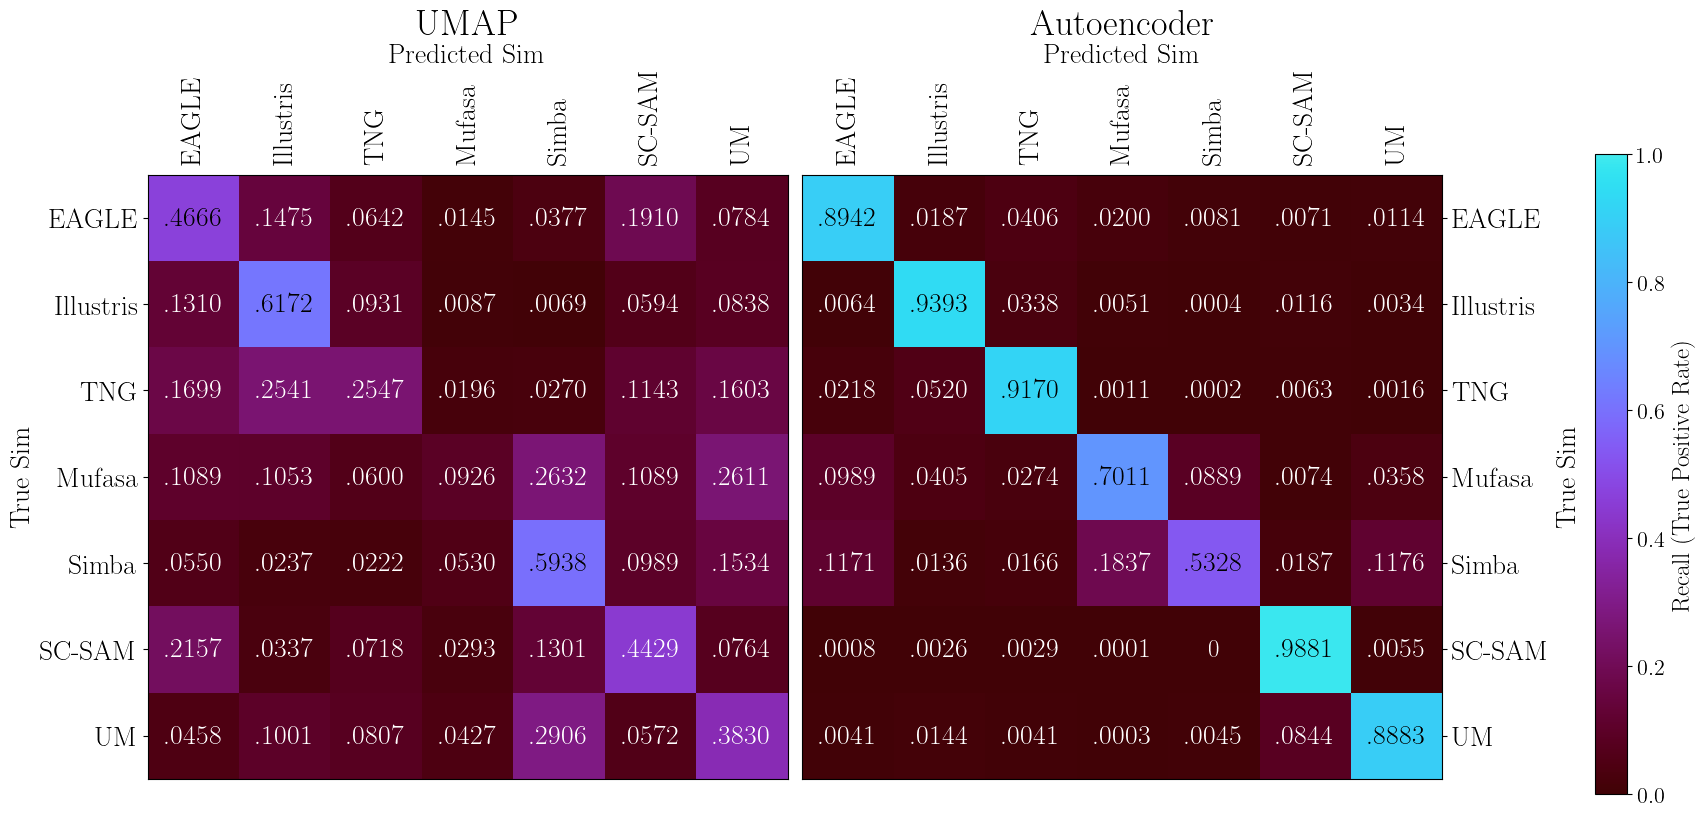

Confusion matrix figure saved: confusion_matrices_unweighted


In [29]:
create_confusion_matrix_figure(
    cm_left=cm_sop_unw, 
    cm_right=cm_ae_unw,
    title_left='UMAP',
    title_right='Autoencoder',
    filename_base='confusion_matrices_unweighted',
    cmap=cmr.gem
)

## Generate Figure 2: Weighted Confusion Matrices

C:\Users\joshs\AppData\Local\Temp\ipykernel_26524\1740468087.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


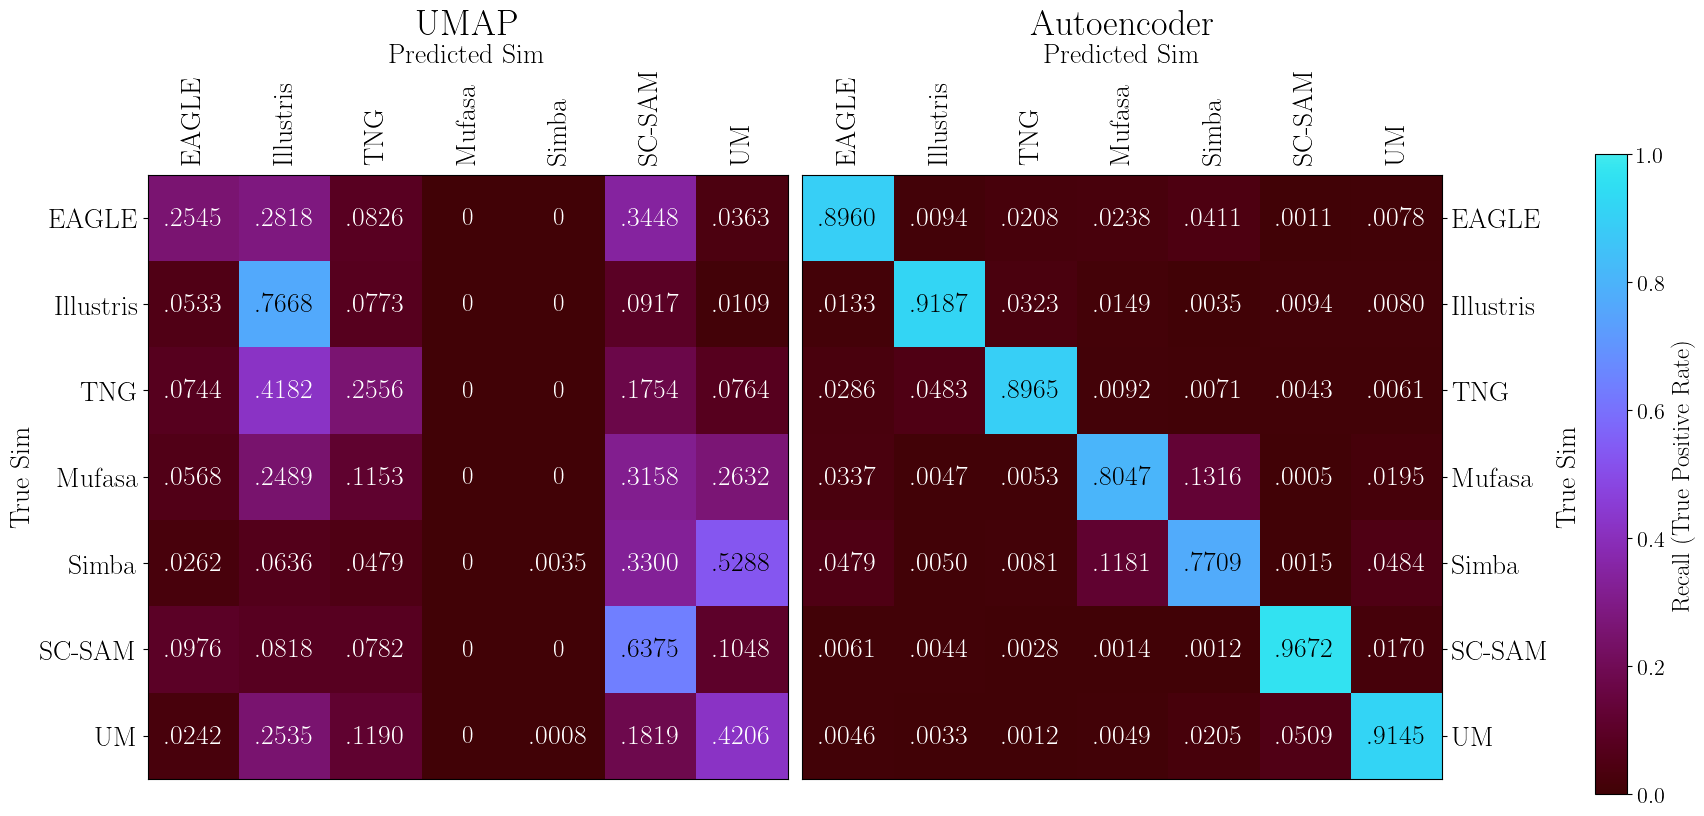

Confusion matrix figure saved: confusion_matrices_weighted


In [30]:
create_confusion_matrix_figure(
    cm_left=cm_sop_w,
    cm_right=cm_ae_w, 
    title_left='UMAP',
    title_right='Autoencoder',
    filename_base='confusion_matrices_weighted',
    cmap=cmr.gem
)

## Detailed Performance Analysis

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_detailed_metrics(true_labels, predictions, method_name):
    """
    Calculate detailed classification metrics.
    """
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    
    print(f"{method_name:>25s}: Acc={accuracy:.3f}, Prec={precision:.3f}, Rec={recall:.3f}, F1={f1:.3f}")
    
    return accuracy, precision, recall, f1

print("Detailed Classification Performance Metrics:")
print("=" * 80)

# Calculate metrics for all methods
calculate_detailed_metrics(true_labels, sop_unw_pred, "SOP (unweighted)")
calculate_detailed_metrics(true_labels, sop_w_pred, "SOP (weighted)")
calculate_detailed_metrics(true_labels, ae_unw_pred, "Autoencoder (unweighted)")
calculate_detailed_metrics(true_labels, ae_w_pred, "Autoencoder (weighted)")

print("\nPer-Simulation Performance (Recall):")
print("=" * 80)
print(f"{'Simulation':>15s} {'SOP_unw':>8s} {'SOP_w':>8s} {'AE_unw':>8s} {'AE_w':>8s}")
print("-" * 55)

for i, sim in enumerate(sim_name):
    print(f"{sim:>15s} {cm_sop_unw[i,i]:>8.3f} {cm_sop_w[i,i]:>8.3f} {cm_ae_unw[i,i]:>8.3f} {cm_ae_w[i,i]:>8.3f}")

Detailed Classification Performance Metrics:
         SOP (unweighted): Acc=0.450, Prec=0.371, Rec=0.407, F1=0.366
           SOP (weighted): Acc=0.494, Prec=0.397, Rec=0.334, F1=0.320
 Autoencoder (unweighted): Acc=0.914, Prec=0.867, Rec=0.837, F1=0.848
   Autoencoder (weighted): Acc=0.913, Prec=0.844, Rec=0.881, F1=0.860

Per-Simulation Performance (Recall):
     Simulation  SOP_unw    SOP_w   AE_unw     AE_w
-------------------------------------------------------
          EAGLE    0.467    0.255    0.894    0.896
      Illustris    0.617    0.767    0.939    0.919
   IllustrisTNG    0.255    0.256    0.917    0.896
         Mufasa    0.093    0.000    0.701    0.805
          Simba    0.594    0.004    0.533    0.771
         SC-SAM    0.443    0.638    0.988    0.967
UniverseMachine    0.383    0.421    0.888    0.915
